In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


In [9]:
# Prepare the directories for ImageDataGenerators.

#!unzip /kaggle/input/dogs-vs-cats/train.zip
#!unzip /kaggle/input/dogs-vs-cats/test1.zip
#!mkdir data data/validation data/train data/validation/dogs data/validation/cats data/train/dogs data/train/cats

!ls

__notebook_source__.ipynb  data  test1	train


In [10]:
# Split into train and validation sets.

#!ls train | grep "dog" | head -1500 | while read a; do mv train/$a data/validation/dogs; done
#!ls train | grep "dog"| while read a; do mv train/$a data/train/dogs; done
#!ls data/validation/dogs | wc

#!ls train | grep "cat" | head -1500 | while read a; do mv train/$a data/validation/cats; done
#!ls train | while read a; do mv train/$a data/train/cats; done

grep: write error: Broken pipe
ls: write error: Broken pipe
   1500    1500   20823
grep: write error: Broken pipe
ls: write error: Broken pipe


In [11]:
# output should be:
# 1500
# 1500
# 11000
# 11000

!ls data/validation/cats | wc -w
!ls data/validation/dogs | wc -w
!ls data/train/cats | wc -w
!ls data/train/cats | wc -w

1500
1500
11000
11000


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Image augmentation (Experimental values)
train_datagen = ImageDataGenerator(rescale=1./255,
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                fill_mode='nearest',
                                        )

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./data/train"
validation_dir = "./data/validation"


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   )

Found 22000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3) ) )
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid') )
          

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [16]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        try:
            accuracy = logs.get('accuracy')
            if ( (accuracy - self.accuracy) < -0.2 ):
                print("accuracy stopped increasing.")
                self.model.stop_training = True
            if( (accuracy - self.accuracy) < 0):
                try:
                    self.going_down += 1
                except NameError :
                    self.going_down = 1
            else :
                self.going_down = 0
            
        except NameError :
            pass
        self.accuracy = float(logs.get('accuracy'))
myCallback()

In [23]:
history=model.fit(train_generator,
         validation_data= validation_generator,
         steps_per_epoch=100,
         epochs=30,
         validation_steps=50,
         verbose=2,
         callbacks=[myCallback()]
        )

Epoch 1/30
100/100 - 65s - loss: 0.5756 - accuracy: 0.6960 - val_loss: 0.5455 - val_accuracy: 0.7650
Epoch 2/30
100/100 - 65s - loss: 0.5603 - accuracy: 0.7195 - val_loss: 0.4689 - val_accuracy: 0.7870
Epoch 3/30
100/100 - 65s - loss: 0.5760 - accuracy: 0.7130 - val_loss: 0.5559 - val_accuracy: 0.7200
Epoch 4/30
100/100 - 65s - loss: 0.5788 - accuracy: 0.7030 - val_loss: 0.4858 - val_accuracy: 0.7500
Epoch 5/30
100/100 - 65s - loss: 0.5581 - accuracy: 0.7220 - val_loss: 0.4694 - val_accuracy: 0.7870
Epoch 6/30
100/100 - 65s - loss: 0.5473 - accuracy: 0.7255 - val_loss: 0.5290 - val_accuracy: 0.7490
Epoch 7/30
100/100 - 71s - loss: 0.5689 - accuracy: 0.7225 - val_loss: 0.4731 - val_accuracy: 0.7950
Epoch 8/30
100/100 - 66s - loss: 0.5423 - accuracy: 0.7220 - val_loss: 0.4138 - val_accuracy: 0.8150
Epoch 9/30
100/100 - 65s - loss: 0.5563 - accuracy: 0.7170 - val_loss: 14.6051 - val_accuracy: 0.5050
Epoch 10/30
100/100 - 65s - loss: 0.6820 - accuracy: 0.7320 - val_loss: 0.4367 - val_accur

<Figure size 432x288 with 0 Axes>

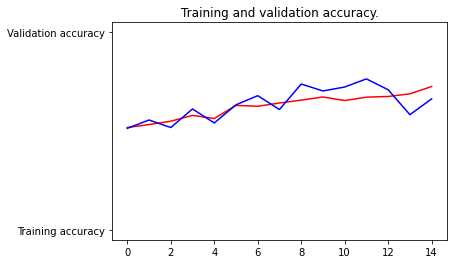

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

cases=range(len(acc))

plt.plot(cases, acc, 'r', "Training accuracy")
plt.plot(cases, val_acc, 'b', "Validation accuracy")
plt.title('Training and validation accuracy.')
plt.figure()

In [66]:
!ls test1 | tail -1

9999.jpg


In [61]:
!pwd

/kaggle/working


In [71]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_img(filename="test1/10447.jpg"):
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()

In [74]:
import cv2 

def predict(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])

    return model.predict_classes(img)

In [81]:
import os
test = os.listdir("test1/")


classes_encoded = [predict(os.path.join("test1",test_case)) for test_case in test ]

array([[1]], dtype=int32)

In [95]:
results = [c[0][0] for c in classes_encoded]
results[431:436]

[1, 1, 1, 1, 0]

In [102]:
submission = pd.read_csv("/kaggle/input/dogs-vs-cats/sampleSubmission.csv")
submission['label'] = results
submission.to_csv('new_dogs_vs_cats.csv',index=False)